In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
base_dir = '/kaggle/input/brain-tumor-mri-dataset'

In [5]:
train_dir = os.path.join(base_dir, 'C:\Users\G VENKATA RAMANA\Downloads\archive (2)\Training')
test_dir = os.path.join(base_dir, 'C:\Users\G VENKATA RAMANA\Downloads\archive (2)\Testing')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2978160593.py, line 1)

In [6]:
train_dir = os.path.join(base_dir, r'C:\Users\G VENKATA RAMANA\Downloads\archive (2)\Training')
test_dir = os.path.join(base_dir, r'C:\Users\G VENKATA RAMANA\Downloads\archive (2)\Testing')

In [7]:
def create_dataframe(directory):
    filepaths = []
    labels = []
    folds = os.listdir(directory)
    for fold in folds:
        foldpath = os.path.join(directory, fold)
        if os.path.isdir(foldpath):
            filelist = os.listdir(foldpath)
            for fpath in filelist:
                fullpath = os.path.join(foldpath, fpath)
                labels.append(fold)
                filepaths.append(fullpath)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [8]:
train_df = create_dataframe(train_dir)

train_df

,filepaths,labels
0,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
1,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
2,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
3,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
4,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
...,...,...
5707,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
5708,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
5709,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
5710,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary


In [9]:
test_df = create_dataframe(test_dir)

test_df

,filepaths,labels
0,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
1,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
2,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
3,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
4,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
...,...,...
1306,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
1307,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
1308,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
1309,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary


In [10]:
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=43)

val_df

,filepaths,labels
185,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
436,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,meningioma
1149,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
999,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,notumor
671,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,notumor
...,...,...
307,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,meningioma
16,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
58,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
277,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma


In [11]:
batch_size = 32  # Increased batch size to utilize P100 GPU memory
image_size = (224, 224)

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [13]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 5712 validated image filenames belonging to 4 classes.


In [15]:
valid_generator = valid_datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 655 validated image filenames belonging to 4 classes.


In [16]:
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 656 validated image filenames belonging to 4 classes.


In [17]:
g_dict = train_generator.class_indices
classes = list(g_dict.keys())

In [18]:
images, labels = next(train_generator)

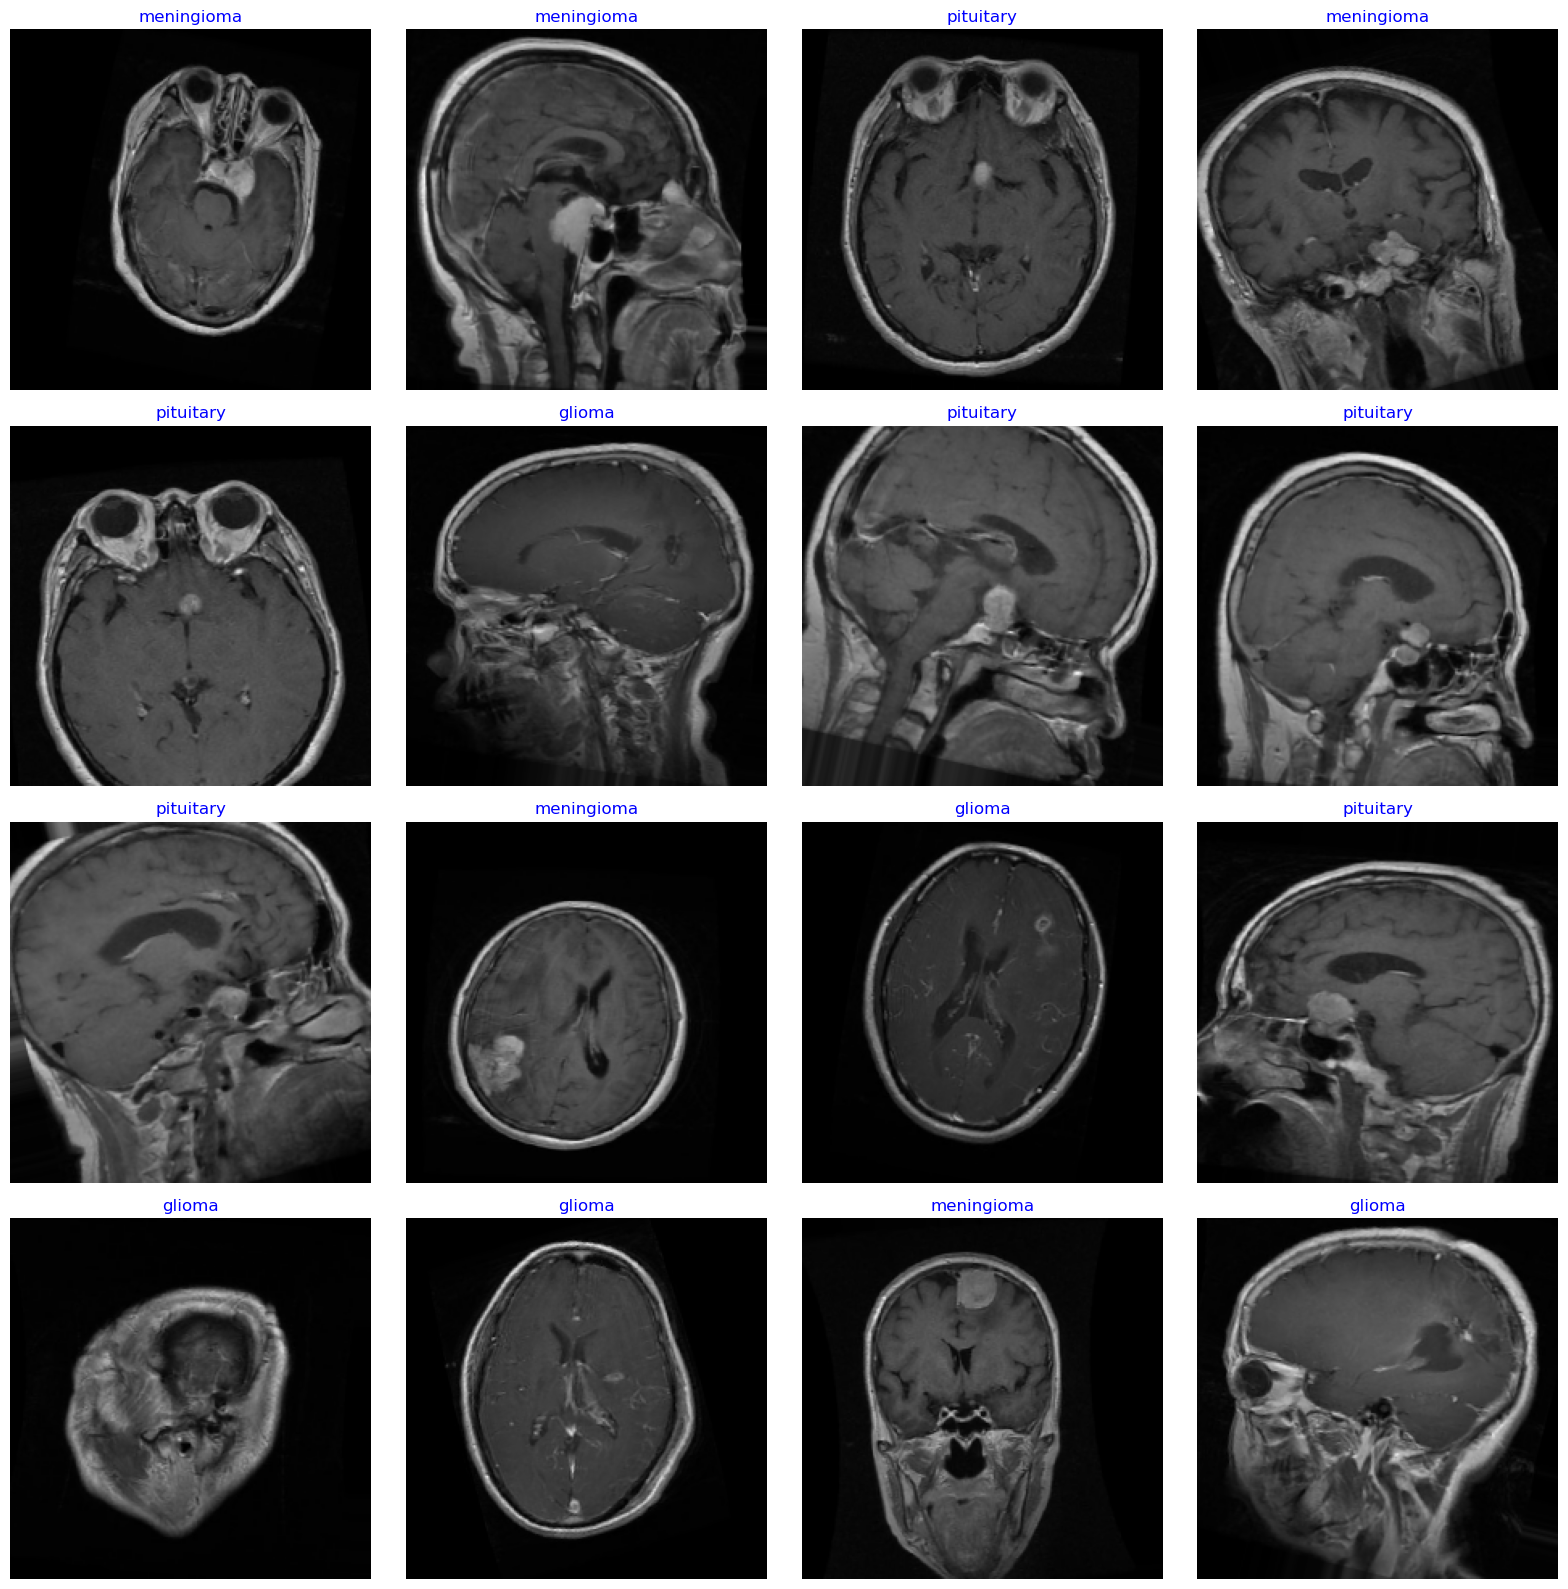

In [19]:
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
class_count = len(train_generator.class_indices)
print("Number of Classes:", class_count)

Number of Classes: 4


In [21]:
# Load the VGG16 model without the top layers
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg.trainable = False  # Freeze the base model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [22]:
from tensorflow.keras import layers, models

In [23]:
# Build the model
vgg_model = models.Sequential([
    base_model_vgg,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(class_count, activation='softmax')
])

In [24]:
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
epochs = 20

history_vgg16 = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1778s 10s/step - accuracy: 0.5034 - loss: 1.1114 - val_accuracy: 0.7703 - val_loss: 0.6734
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7188 - loss: 0.6028 - val_accuracy: 0.6667 - val_loss: 0.8986
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3201s 18s/step - accuracy: 0.7930 - loss: 0.5672 - val_accuracy: 0.7797 - val_loss: 0.6115
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.7812 - loss: 0.7343 - val_accuracy: 0.6000 - val_loss: 0.9993
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 4414s 25s/step - accuracy: 0.8266 - loss: 0.4656 - val_accuracy: 0.8250 - val_loss: 0.5232
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.8438 - loss: 0.6097 - val_accuracy: 0.6667 - val_loss: 0.8288
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8307 - loss: 0.4678 